In [1]:
using LinearAlgebra
using Random
using Plots
using ProgressBars
using Statistics
using Distributions
gr()

Plots.GRBackend()

## How cue matrix is mapped to meaning matrix

* $C$ is the cue matrix, with $n$ instances in row and $k_c$ cue features in columns.
* $M$ is the meaning matrix, with $n$ instances in row and $k_m$ semantic features in columns
* $F$ is the transformation matrix, it maps cues to meanings.

$
\begin{align}
\underset{n \times k_c}{C} \cdot \underset{k_c \times k_m}{F} &= \underset{n \times k_m}{M} \\
C^\intercal C \cdot F &= C^\intercal M \\
F &= \overbrace{\underset{k_c \times k_c}{(C^\intercal C) ^ {-1}} \underset{k_c \times n}{C^\intercal}}^{\textrm{pseudoinverse}} M \\
%
C \cdot \overbrace{C^{+} M}^{F} &= 
\overbrace{C C^{+}}^{\tilde{I}} \cdot M = 
\overbrace{
    \underset{n \times k_c}{C} \cdot \underset{k_c \times k_c}{(C^\intercal C) ^ {-1}} 
    \underset{k_c \times n}{C^\intercal}}^{\tilde{I} \textrm{ is an identity if C is full row rank}} 
    M = \hat{M}
\end{align}
$

* if $\tilde{I}$ is an identity matrix, the mapping to M would be exact; otherwise, $\hat{M}$ would be a linear combinations of noises presented in $\tilde{I}$
* To alleviate the noise, M could be sparse. A sparse matrix would be resistant to the noise in the $\tilde{I}$

## function definition

In [2]:
function make_zero(A, idx_list)
    for idx = idx_list
        setindex!(A, 0, idx...)
    end
end

function make_matrix(n, k; sparseness=0., centered=false)
    
    A = rand(n, k)
    if centered
        A = A .- 0.5
    end
    
    idx_list = reshape(collect(Iterators.product(1:n, 1:k)), n*k, 1)
    shuffle!(idx_list)
    sub_list = idx_list[1:Int(length(idx_list) * sparseness), 1]
    
    make_zero(A, sub_list)
    return A
end

make_matrix (generic function with 1 method)

In [3]:
function transform(
        A:: Array{Float64, 2}, # N x Ka
        B:: Array{Float64, 2})  # N x Kb
    F = inv(A'A) * A' * B
end

transform (generic function with 1 method)

In [4]:
function predict(
        pred_vec::Vector{Float64}, # K
        ref_norm_matrix::Array{Float64, 2}) # N x K
    r1 = ref_norm_matrix[1,:]
    @assert abs(r1'r1 - 1) < 1e-5
    @assert size(pred_vec)[1] == size(ref_norm_matrix)[2]    
    
    scores = ref_norm_matrix * pred_vec / sqrt(pred_vec'pred_vec)
    candid_idx = argmax(scores)[1]
end

predict (generic function with 1 method)

In [5]:
function check_accuracy(
        C:: Array{Float64, 2}, # N x Kc
        S:: Array{Float64, 2})  # N x Ks
    acc = []    
    F = transform(C, S);    
    Slen = [sqrt(r'r) for r in eachrow(S)];
    Snorm = diagm(1 ./ Slen) * S;
    
    Shat = C * F
    Shat_len = [sqrt(r'r) for r in eachrow(Shat)];
    Shat_norm = diagm(1 ./ Shat_len) * Shat;
    
    # compute accuracy
    for n = 1:size(Shat, 1)
        candid_idx = predict(Shat[n, :], Snorm) 
        push!(acc, candid_idx==n ? 1 : 0)    
    end
    
    # compute distance
    dist = 0
    for ridx = 1:size(Shat, 1)
        dist_x = Shat_norm[ridx, :]'Snorm[ridx, :]        
        dist += dist_x
    end
    return sum(acc)/length(acc), dist/size(Shat, 1)
end

check_accuracy (generic function with 1 method)

In [6]:
C = make_matrix(100, 10, sparseness=0)
S = make_matrix(100, 100, sparseness=0)
check_accuracy(C, S)

(0.1, 0.8814479881640791)

## Effect of cue matrix feature counts (not centered)

In [7]:
acc_replicas = []
matdiff_replicas = []
N = 1000
xs = collect(Iterators.flatten([0:20:300, 300:100:1000]))
for replica = ProgressBar(1:10)
    acc = []
    matdiff = []
    for k = xs
        Kc = k
        Km = 200
        C = make_matrix(N, Kc, sparseness=0)
        M = make_matrix(N, Km, sparseness=0)
        acc_x, matdiff_x = check_accuracy(C, M)
        push!(acc, acc_x)
        push!(matdiff, matdiff_x)
    end
    push!(acc_replicas, acc)
    push!(matdiff_replicas, matdiff)
end

100.0%┣██████████████████████████████████████████┫ 10/10 [00:12<00:00, 0.7 it/s]


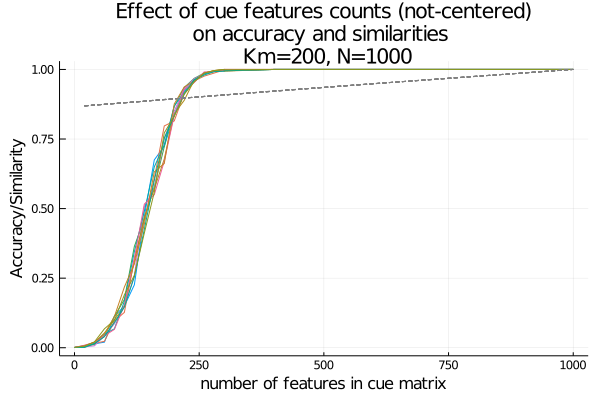

In [8]:
plot(xs, acc_replicas, legend=false, linestyle=:solid, 
    ylabel="Accuracy/Similarity", 
    xlabel="number of features in cue matrix", 
    title="Effect of cue features counts (not-centered)\n" *
        "on accuracy and similarities \n " *
        "Km=200, N=1000")
plot!(xs, matdiff_replicas, legend=false, linestyle=:dash, linecolor=:gray)

## Effect of cue matrix feature counts (centered)

In [9]:
acc_replicas = []
matdiff_replicas = []
N = 1000
xs = collect(Iterators.flatten([0:20:300, 300:100:1000]))
for replica = ProgressBar(1:10)
    acc = []
    matdiff = []
    for k = xs
        Kc = k
        Km = 200
        C = make_matrix(N, Kc, sparseness=0, centered=true)
        M = make_matrix(N, Km, sparseness=0, centered=true)
        acc_x, matdiff_x = check_accuracy(C, M)
        push!(acc, acc_x)
        push!(matdiff, matdiff_x)
    end
    push!(acc_replicas, acc)
    push!(matdiff_replicas, matdiff)
end

100.0%┣██████████████████████████████████████████┫ 10/10 [00:13<00:00, 0.7 it/s]


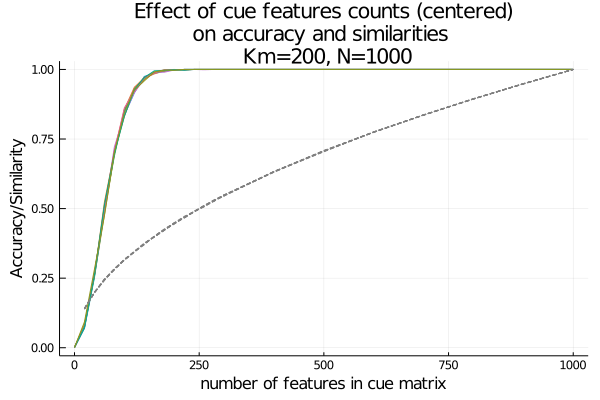

In [10]:
plot(xs, acc_replicas, legend=false, linestyle=:solid, 
    ylabel="Accuracy/Similarity", 
    xlabel="number of features in cue matrix", 
    title="Effect of cue features counts (centered)\n" *
        "on accuracy and similarities \n " *
        "Km=200, N=1000")
plot!(xs, matdiff_replicas, legend=false, linestyle=:dash, linecolor=:gray)

## Effect of sparseness (not-centered)

In [11]:
sp = 0:0.1:0.9
N = 1000
acc_sp_replicas = [] 
for replica = ProgressBar(1:10)
    acc_sp = []
    for sp_x = sp
        Kc = 100
        Ks = 200
        C = make_matrix(N, Kc, sparseness=0)
        S = make_matrix(N, Ks, sparseness=sp_x)
        acc, diff = check_accuracy(C, S)
        push!(acc_sp, acc)        
    end
    push!(acc_sp_replicas, acc_sp)
end

100.0%┣██████████████████████████████████████████┫ 10/10 [00:04<00:00, 2.0 it/s]


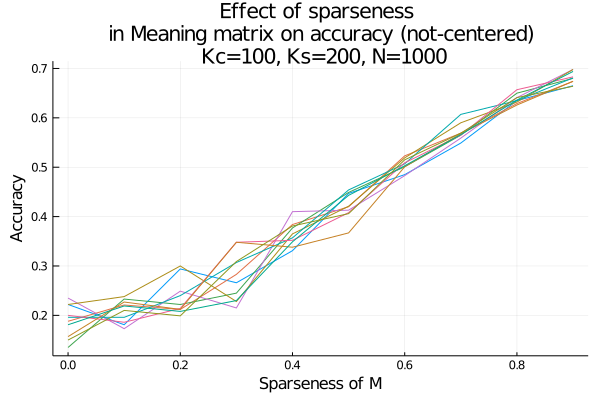

In [12]:
plot(sp, acc_sp_replicas, legend=false, 
    ylabel="Accuracy", xlab="Sparseness of M",
    title="Effect of sparseness \n in Meaning matrix on accuracy (not-centered) \n Kc=100, Ks=200, N=1000") 

## Effect of sparseness (centered)

In [13]:
sp = 0:0.1:0.9
N = 1000
acc_sp_replicas = [] 
for replica = ProgressBar(1:10)
    acc_sp = []
    for sp_x = sp
        Kc = 100
        Ks = 200
        C = make_matrix(N, Kc, sparseness=0, centered=true)
        S = make_matrix(N, Ks, sparseness=sp_x, centered=true)
        acc, diff = check_accuracy(C, S)
        push!(acc_sp, acc)        
    end
    push!(acc_sp_replicas, acc_sp)
end

100.0%┣██████████████████████████████████████████┫ 10/10 [00:05<00:00, 1.9 it/s]


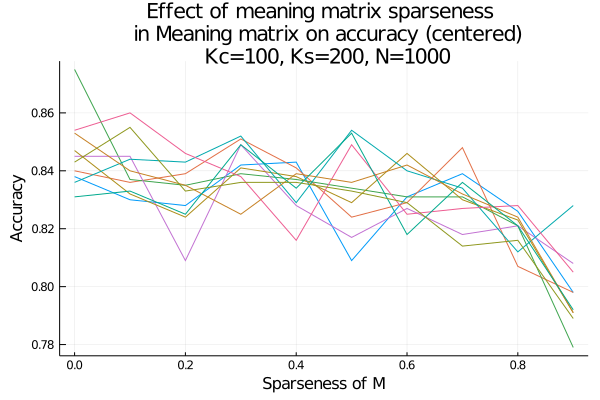

In [14]:
plot(sp, acc_sp_replicas, legend=false, 
    ylabel="Accuracy", xlab="Sparseness of M",
    title="Effect of meaning matrix sparseness \n in Meaning matrix on accuracy (centered)\n Kc=100, Ks=200, N=1000") 

# Effect of sparseness (cue-matrix, centered)

In [15]:
sp = 0:0.1:0.9
N = 1000
acc_sp_replicas = [] 
for replica = ProgressBar(1:10)
    acc_sp = []
    for sp_x = sp
        Kc = 100
        Ks = 200
        C = make_matrix(N, Kc, sparseness=sp_x, centered=true)
        S = make_matrix(N, Ks, sparseness=0, centered=false)
        acc, diff = check_accuracy(C, S)
        push!(acc_sp, acc)        
    end
    push!(acc_sp_replicas, acc_sp)
end

100.0%┣██████████████████████████████████████████┫ 10/10 [00:04<00:00, 2.0 it/s]


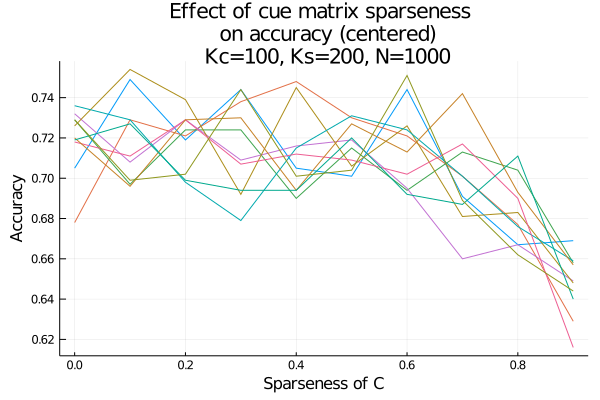

In [16]:
plot(sp, acc_sp_replicas, legend=false, 
    ylabel="Accuracy", xlab="Sparseness of C",
    title="Effect of cue matrix sparseness \n on accuracy (centered)\n Kc=100, Ks=200, N=1000") 

## The effect of ellipsoid-shaped data

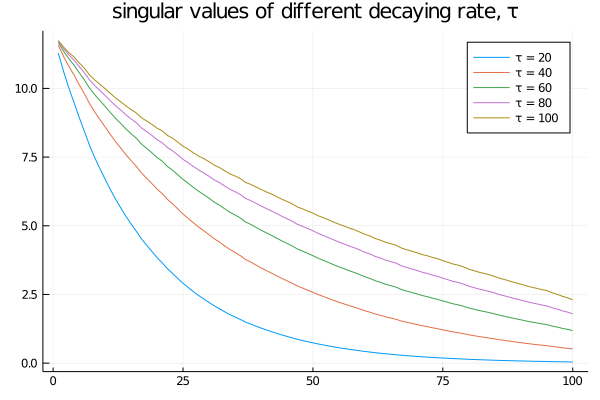

In [17]:
C = make_matrix(1000, 100, centered=true)
u, s, vt = svd(C);
p0 = plot(s .* (collect(exp(-x/20) for x in 1:length(s))), label="τ = 20", title="singular values of different decaying rate, τ")
for tau = 40:20:100
    plot!(s .* (collect(exp(-x/tau) for x in 1:length(s))), label="τ = $(tau)")
end
Plots.display(p0)

In [18]:
taus = 20:20:100
N = 1000
acc_sp_replicas = [] 
for replica = ProgressBar(1:10)
    acc_sp = []
    Kc = 100
    Ks = 200
    C = make_matrix(N, Kc, sparseness=0, centered=true)
    S = make_matrix(N, Ks, sparseness=0, centered=true)
    for tau = taus
        u, s, vt = svd(C)
        s_comp = s .* collect(exp(-x/tau) for x in 1:length(s))
        C_comp = u * diagm(s_comp) * vt;
        acc, diff = check_accuracy(C_comp, S)
        push!(acc_sp, acc)        
    end
    push!(acc_sp_replicas, acc_sp)
end

100.0%┣██████████████████████████████████████████┫ 10/10 [00:03<00:00, 3.5 it/s]


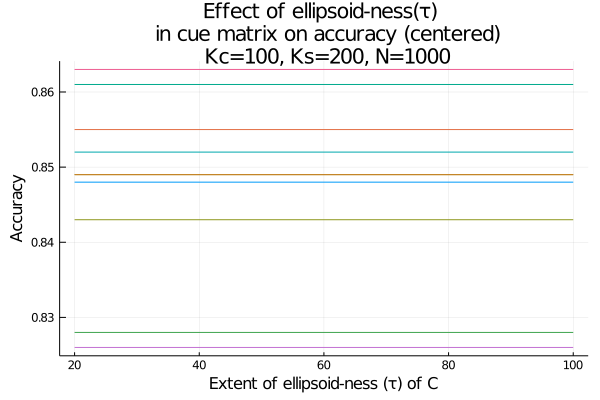

In [19]:
plot(taus, acc_sp_replicas, legend=false, 
    ylabel="Accuracy", xlab="Extent of ellipsoid-ness (τ) of C", 
    title="Effect of ellipsoid-ness(τ) \n in cue matrix on accuracy (centered)\n Kc=100, Ks=200, N=1000") 

## Correlations of Meaning matrix

In [20]:
rs = 0:0.1:0.8
N = 1000
acc_sp_replicas = [] 
for replica = ProgressBar(1:10)
    acc_sp = []
    Kc = 100
    Ks = 200
    C = make_matrix(N, Kc, sparseness=0, centered=true)
    for r = rs
        Σ = fill(r, Ks, Ks)
        Σ[diagind(Σ)] .= 1
        mvn = MvNormal(zeros(Ks), Σ)
        S = copy(rand(mvn, N)');
        acc, diff = check_accuracy(C, S)
        push!(acc_sp, acc)        
    end
    push!(acc_sp_replicas, acc_sp)
end

100.0%┣██████████████████████████████████████████┫ 10/10 [00:04<00:00, 2.4 it/s]


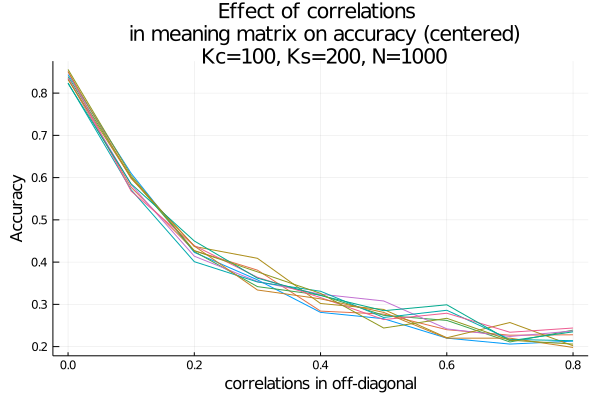

In [21]:
plot(rs, acc_sp_replicas, legend=false, 
    ylabel="Accuracy", xlab="correlations in off-diagonal", 
    title="Effect of correlations \n in meaning matrix on accuracy (centered)\n Kc=100, Ks=200, N=1000") 

## How pseudoinverse looks like in rank deficiency

┌ Info: Saved animation to 
│   fn = E:\LangOn\OntoDeepLex\notebooks\00-incubator\pinv_fps15.gif
└ @ Plots C:\Users\seantyh\.julia\packages\Plots\XbAWb\src\animation.jl:104


Plots.AnimatedGif("E:\\LangOn\\OntoDeepLex\\notebooks\\00-incubator\\pinv_fps15.gif")
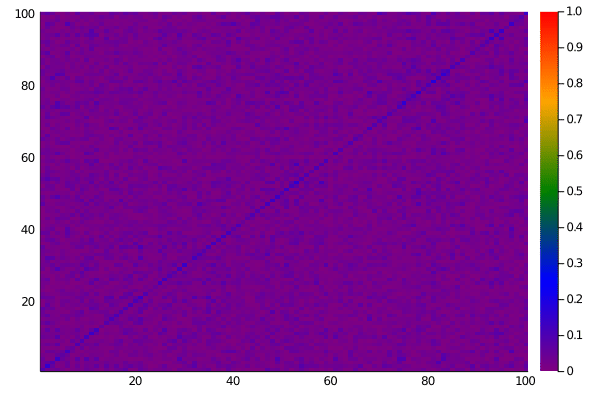

In [11]:
anim = @animate for k = 10:100
    A = rand(100, k)
    A2 = A * pinv(A)
    heatmap(abs.(A2), clims=(0,1), c=:rainbow)
end
gif(anim, "pinv_fps15.gif", fps=15)